# 自行车租赁回归分析（练习）

+ 参考资料：https://blog.csdn.net/Caesar1993_Wang/article/details/80310491?utm_source=blogxgwz22

## 导入并理解数据

In [1]:
import pandas as pd

train_data = pd.read_csv('./input/train.csv')
test_data = pd.read_csv('./input/test.csv')

In [2]:
# 只有前面 9 个是特征
train_data.shape

(10886, 12)




+ casual - number of non-registered user rentals initiated，未注册用户租借数量
+ registered - number of registered user rentals initiated，注册用户租借数量
+ count - number of total rentals：总租借数量

In [3]:
# 看一看训练数据集和测试数据集
train_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
# test_data.head()

In [5]:
# 居然没有缺失值
# train_data.info() # 10886 条数据均无缺失值
# test_data.info() # 6493 条数据均无缺失值

In [6]:
train_data.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [7]:
# 合并训练数据集与测试数据集，以便一起做特征处理，
# 比赛题目可以这么做，真实项目是没有测试数据集的
data_all = train_data.append(test_data)
# data_all

/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [8]:
data_all['year'] = data_all['datetime'].map(
    lambda x: x.split()[0].split('-')[0]).astype(np.int32)
data_all['month'] = data_all['datetime'].map(
    lambda x: x.split()[0].split('-')[1]).astype(np.int32)
data_all['day'] = data_all['datetime'].map(
    lambda x: x.split()[0].split('-')[2]).astype(np.int32)
data_all['hour'] = data_all['datetime'].map(
    lambda x: x.split()[1].split(':')[0]).astype(np.int32)

# data_all

In [9]:
# 
data_all['date'] = data_all['datetime'].map(lambda x: x.split()[0])

In [10]:
# data_all['date']

In [11]:
# 得到这一天是星期几
data_all['weekday'] = pd.to_datetime(data_all['date']).dt.weekday_name.map({'Monday':1,'Tuesday':2,'Wednesday':3,
                                         'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7})

In [12]:
# 把原始的 datetime 字段去掉
data_all = data_all.drop('datetime', axis=1)
data_all.head()

,atemp,casual,count,holiday,humidity,registered,season,temp,weather,windspeed,workingday,year,month,day,hour,date,weekday
0,14.395,3.0,16.0,0,81,13.0,1,9.84,1,0.0,0,2011,1,1,0,2011-01-01,6
1,13.635,8.0,40.0,0,80,32.0,1,9.02,1,0.0,0,2011,1,1,1,2011-01-01,6
2,13.635,5.0,32.0,0,80,27.0,1,9.02,1,0.0,0,2011,1,1,2,2011-01-01,6
3,14.395,3.0,13.0,0,75,10.0,1,9.84,1,0.0,0,2011,1,1,3,2011-01-01,6
4,14.395,0.0,1.0,0,75,1.0,1,9.84,1,0.0,0,2011,1,1,4,2011-01-01,6


In [13]:
# 按照如下顺序，重排特征列
cols = ['year', 'month', 'day', 'weekday', 'hour', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
        'humidity', 'windspeed', 'casual', 'registered', 'count']

data_all = data_all.reindex(columns=cols)
# data_all[cols] 这样写也行
# data_all.loc[:, cols] 这样写也行

In [14]:
# 接下来分离训练数据集与测试数据集
train = data_all.iloc[:train_data.shape[0]]
test = data_all.iloc[train_data.shape[0]:]

特征工作告一段落，真的是很简单的特征工程了。

In [18]:
correlation = train.corr()
correlation

,year,month,day,weekday,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
year,1.000000,-0.004932,0.001800,-0.003785,-0.004234,-0.004797,0.012021,-0.002482,-0.012548,0.061226,0.058540,-0.078606,-0.015221,0.145241,0.264265,0.260403
month,-0.004932,1.000000,0.001974,-0.002266,-0.006818,0.971524,0.001731,-0.003394,0.012144,0.257589,0.264173,0.204537,-0.150192,0.092722,0.169451,0.166862
day,0.001800,0.001974,1.000000,-0.011070,0.001132,0.001729,-0.015877,0.009829,-0.007890,0.015551,0.011866,-0.011335,0.036157,0.014109,0.019111,0.019826
weekday,-0.003785,-0.002266,-0.011070,1.000000,-0.002925,-0.010553,-0.191832,-0.704267,-0.047692,-0.038466,-0.040235,-0.026507,-0.024804,0.246959,-0.084427,-0.002283
hour,-0.004234,-0.006818,0.001132,-0.002925,1.000000,-0.006546,-0.000354,0.002780,-0.022740,0.145430,0.140343,-0.278011,0.146631,0.302045,0.380540,0.400601
season,-0.004797,0.971524,0.001729,-0.010553,-0.006546,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.096758,0.164011,0.163439
holiday,0.012021,0.001731,-0.015877,-0.191832,-0.000354,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,0.043799,-0.020956,-0.005393
workingday,-0.002482,-0.003394,0.009829,-0.704267,0.002780,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,-0.319111,0.119460,0.011594
weather,-0.012548,0.012144,-0.007890,-0.047692,-0.022740,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.135918,-0.109340,-0.128655
temp,0.061226,0.257589,0.015551,-0.038466,0.145430,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.467097,0.318571,0.394454


In [19]:
# 和最终预测变量 “count” 相关的变量的相关系数，按照降序排序
influence_order = correlation['count'].sort_values(ascending=False)
influence_order

count         1.000000
registered    0.970948
casual        0.690414
hour          0.400601
temp          0.394454
atemp         0.389784
year          0.260403
month         0.166862
season        0.163439
windspeed     0.101369
day           0.019826
workingday    0.011594
weekday      -0.002283
holiday      -0.005393
weather      -0.128655
humidity     -0.317371
Name: count, dtype: float64

In [21]:
# 正相关负相关一起算
influence_order_abs = abs(correlation['count']).sort_values(ascending=False)
influence_order_abs

count         1.000000
registered    0.970948
casual        0.690414
hour          0.400601
temp          0.394454
atemp         0.389784
humidity      0.317371
year          0.260403
month         0.166862
season        0.163439
weather       0.128655
windspeed     0.101369
day           0.019826
workingday    0.011594
holiday       0.005393
weekday       0.002283
Name: count, dtype: float64

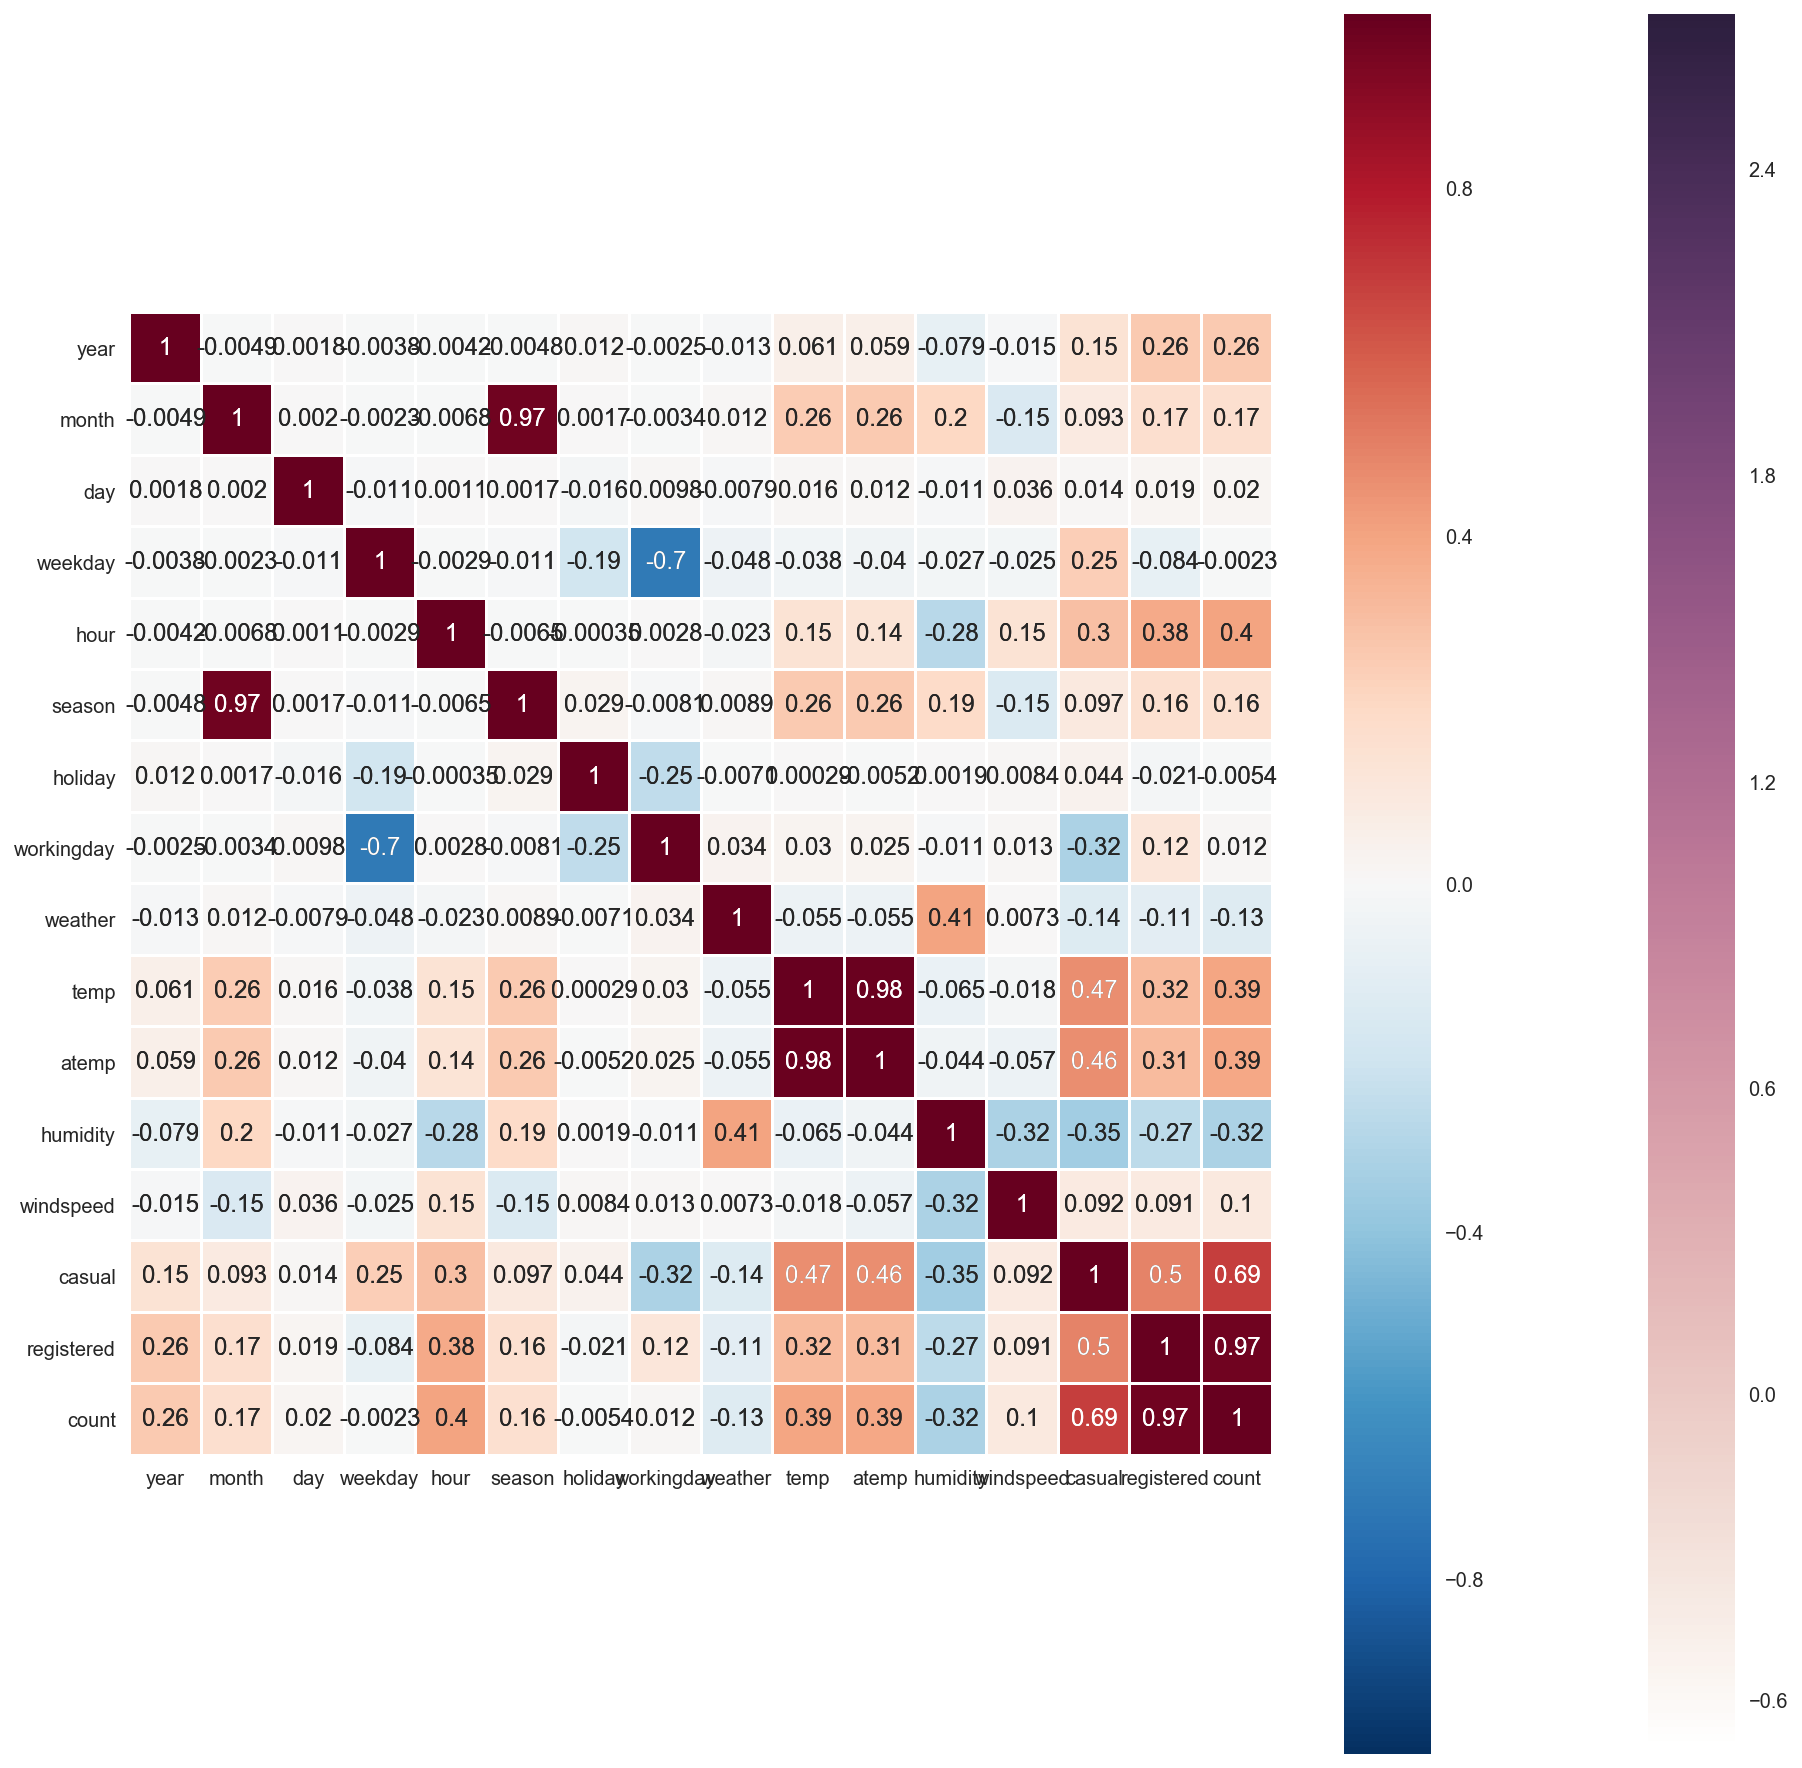

In [26]:
# 2、作相关性分析的热力图
import matplotlib.pyplot as plt
import seaborn as sns

f, ax = plt.subplots(figsize=(16, 16))
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
sns.heatmap(correlation, annot=True, center=1, cmap=cmap, linewidths=1, ax=ax)
sns.heatmap(correlation, vmax=1, square=True, annot=True, linewidths=1)
plt.show()


可以看出不同的特征对于最终的变量 `count` 的影响不同。先别急，我们做一些探索性数据分析。

/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


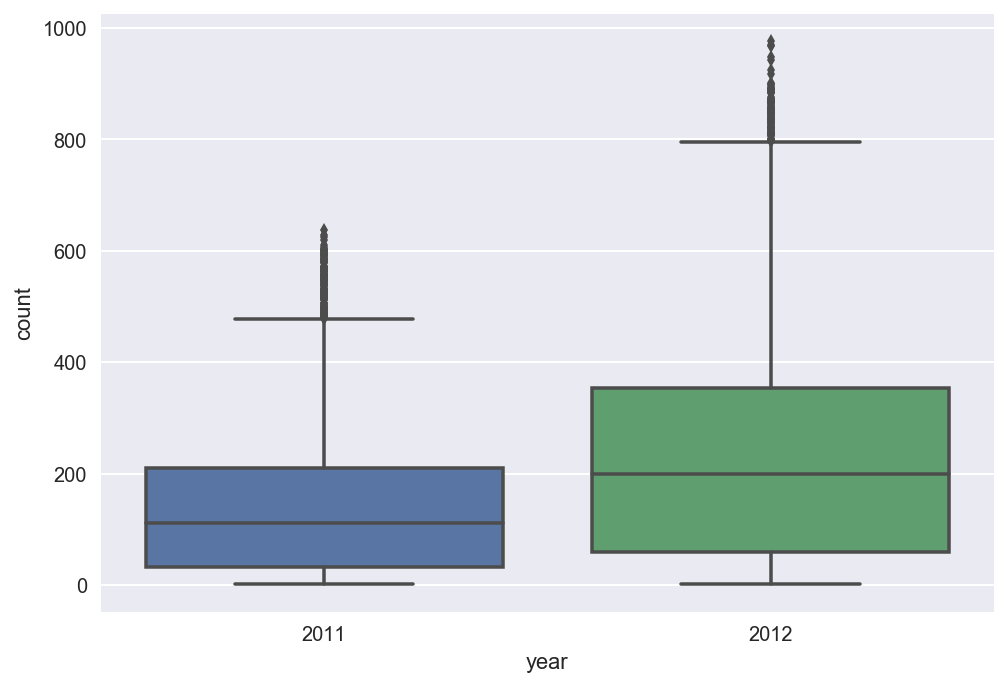

In [30]:
sns.boxplot(train['year'], train['count'])

/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


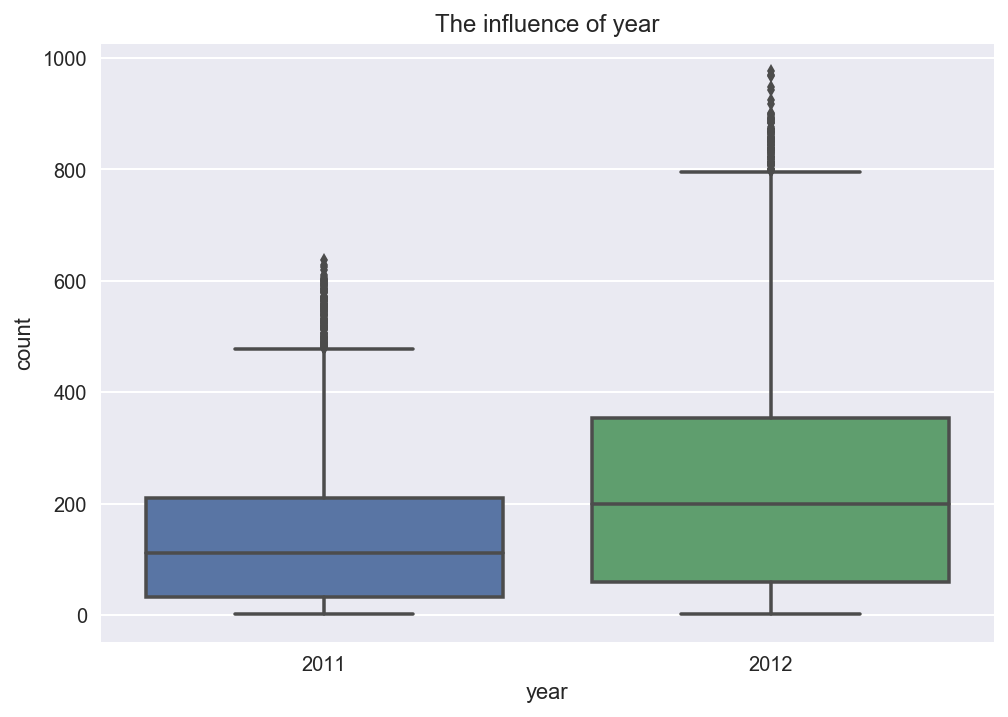

In [32]:
# 也可以这样写，这是回归问题，所以没有设置 hue
sns.boxplot(x='year', y='count', data=train)
plt.title('The influence of year') # influence 影响
plt.show()

In [35]:
train['year'].unique()

array([2011, 2012])

In [ ]:
train[['year', 'count']]

In [36]:
train['month'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [ ]:
train[['month', 'count']]

/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)
/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/scipy/stats/stats.py:1626: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


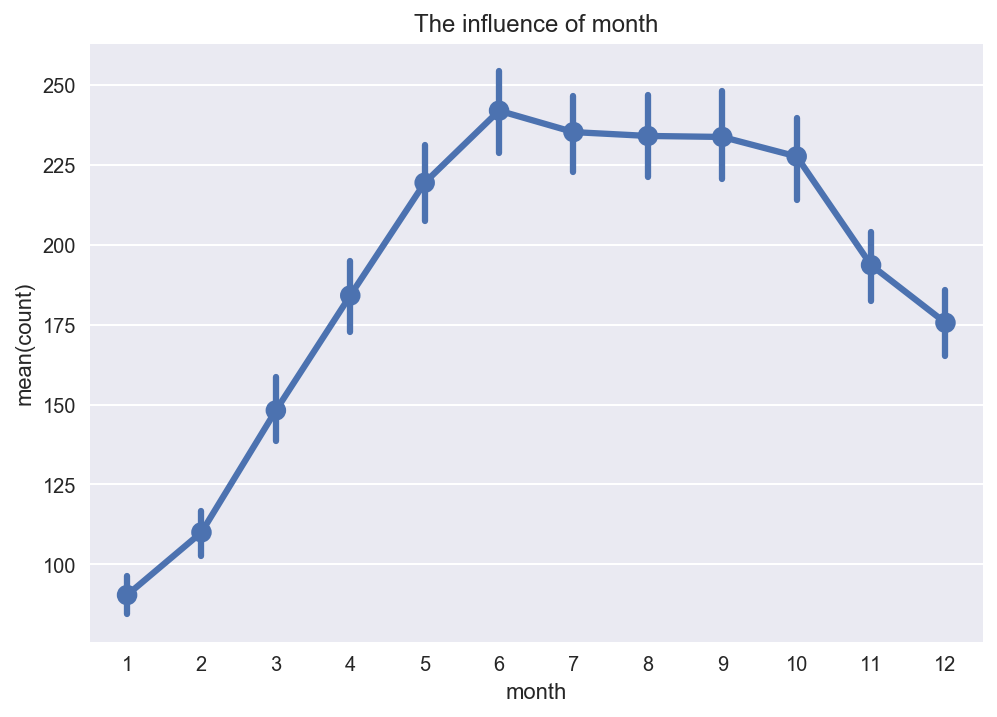

In [48]:
# 月份的影响
sns.pointplot(train['month'], train['count'])
plt.title("The influence of month")
plt.show()

pointplot 图计算的是每一个月份的平均值，我们可以使用 groupby 函数验证一下。

In [42]:
# 我这种写法其实是语法糖，我更习惯的一种写法
# month 一定是离散型变量，count 一定是连续变量
train.groupby('month')['count'].mean()

month
1      90.366516
2     110.003330
3     148.169811
4     184.160616
5     219.459430
6     242.031798
7     235.325658
8     234.118421
9     233.805281
10    227.699232
11    193.677278
12    175.614035
Name: count, dtype: float64

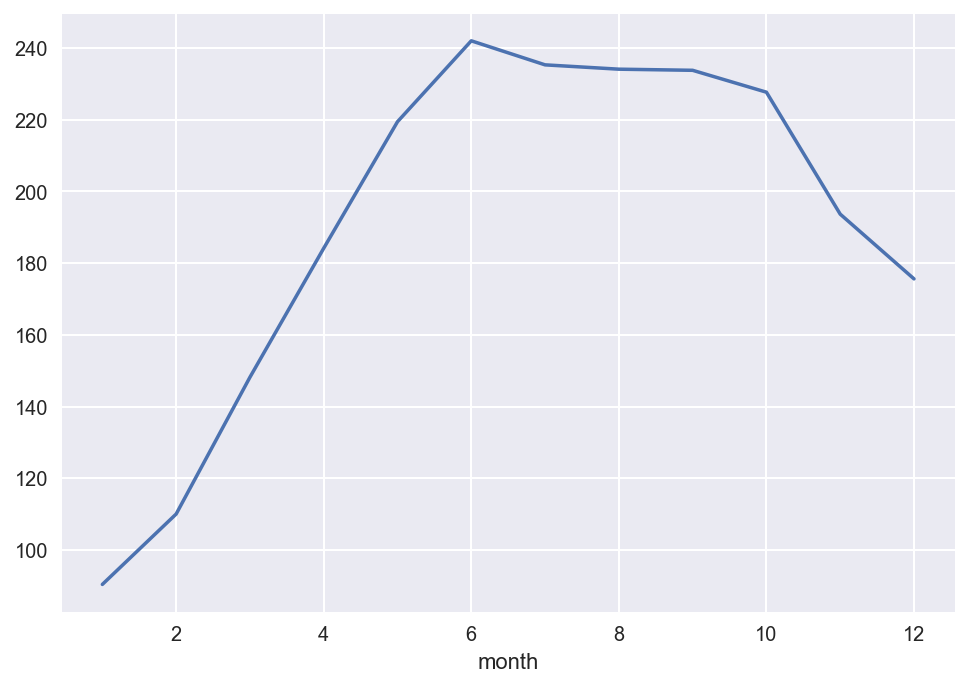

In [43]:
# 也可以使用 pandas 提供的绘图功能直接绘图
train.groupby('month')['count'].mean().plot()

/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)
/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/scipy/stats/stats.py:1626: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


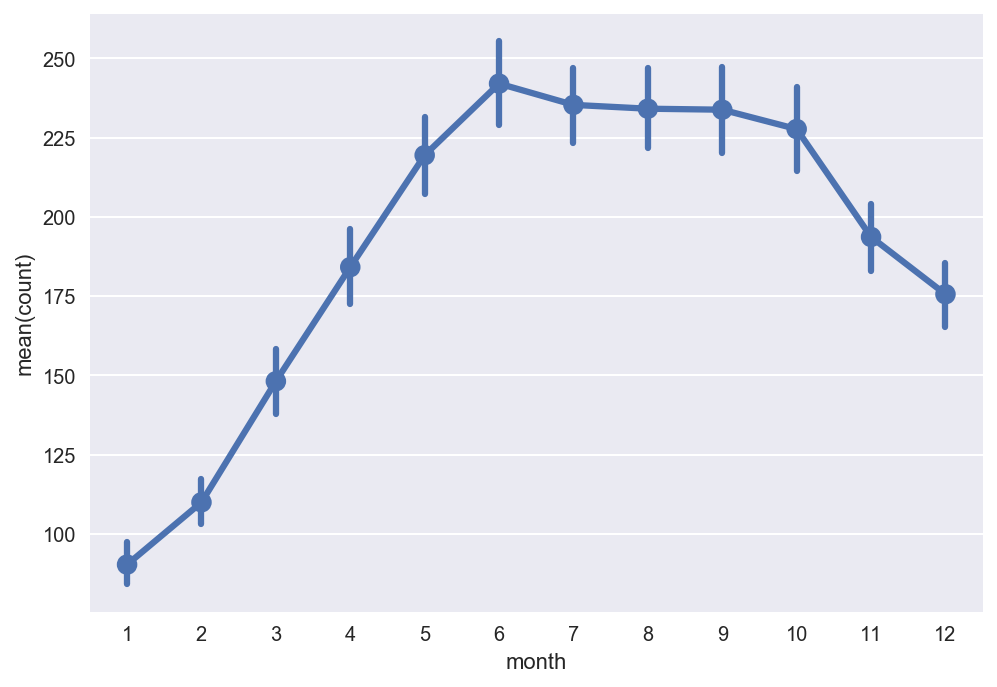

In [49]:
# 还可以这样写
sns.pointplot(x='month', y='count', data=train)
plt.show()

In [50]:
# 季节维度

In [52]:
train['season'].unique()

array([1, 2, 3, 4])

In [ ]:
train[['season', 'count']]

/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


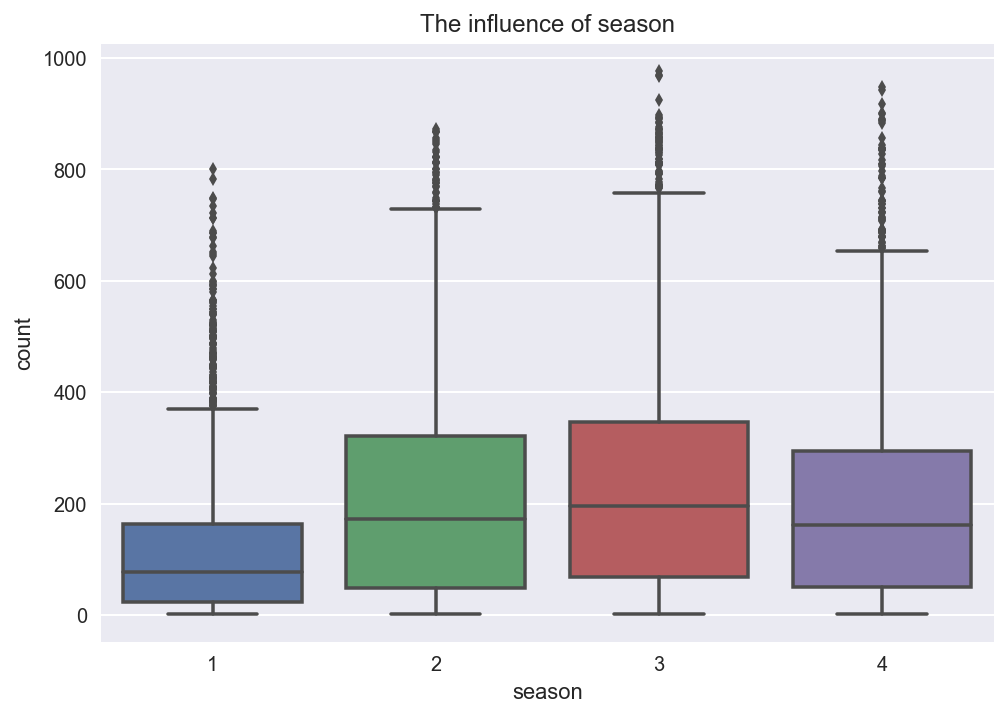

In [55]:
sns.boxplot(x='season', y='count', data=train)
plt.title("The influence of season")
plt.show()

In [57]:
train['hour'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [ ]:
train[['hour', 'count']]

/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


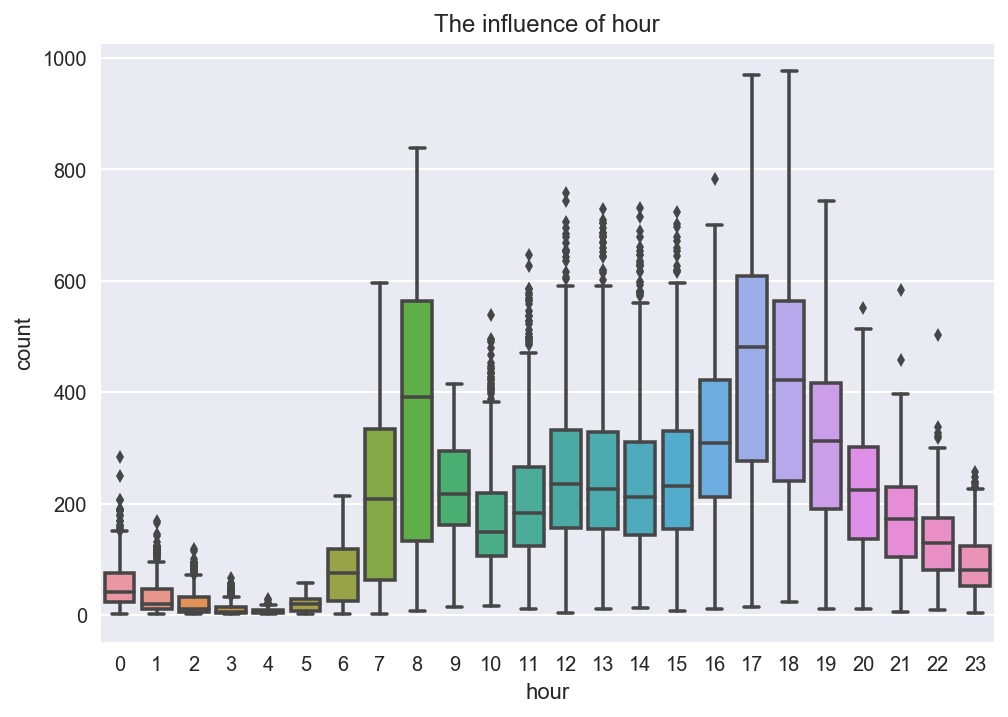

In [59]:
sns.boxplot(x='hour', y='count', data=train)
plt.title("The influence of hour")
plt.show()

/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)
/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/scipy/stats/stats.py:1626: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


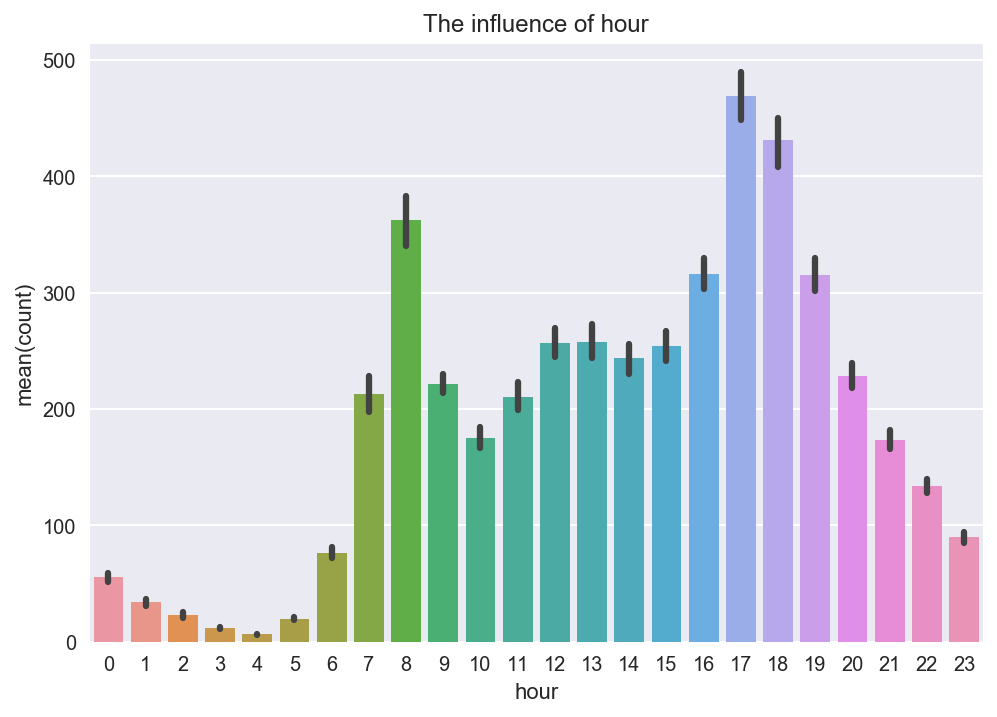

In [60]:
# 画成直方图，计算的是平均值
sns.barplot(x='hour', y='count', data=train)
plt.title("The influence of hour")
plt.show()

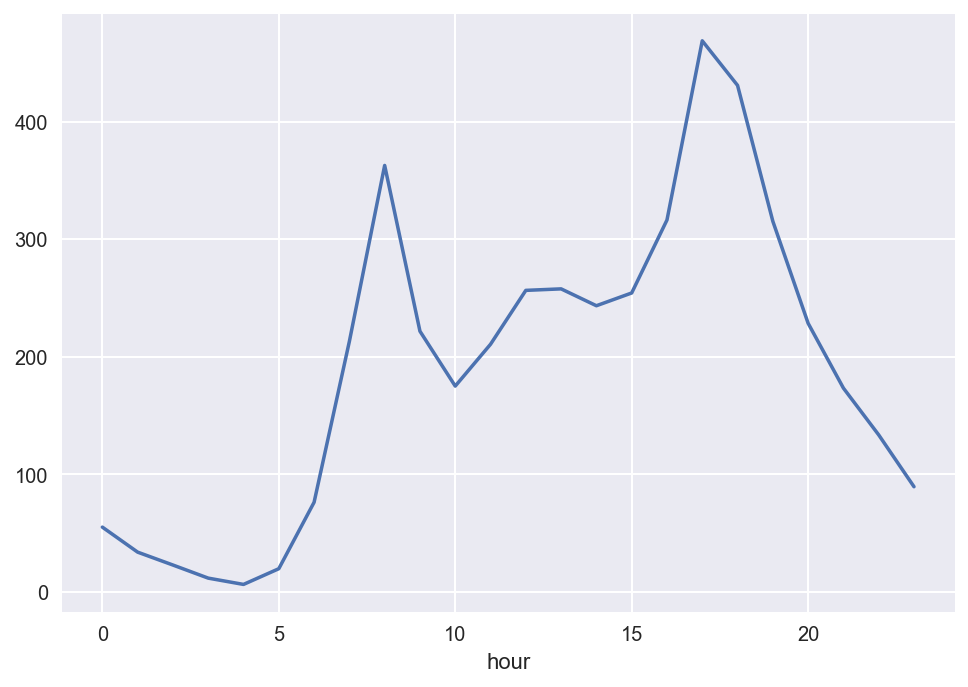

In [65]:
# 默认是折线图
train.groupby('hour')['count'].mean().plot()

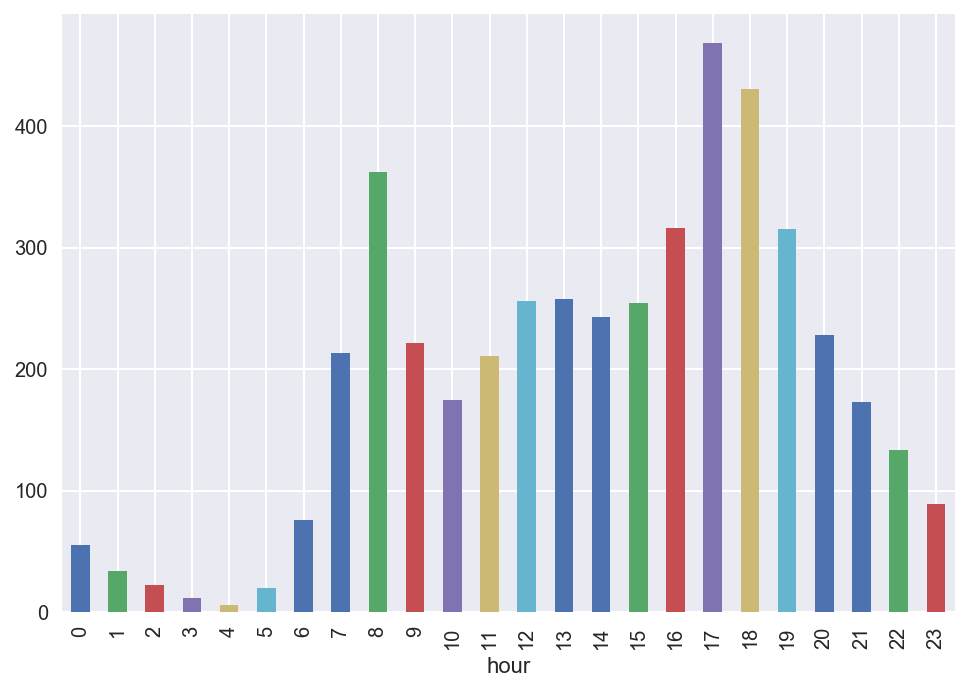

In [64]:
train.groupby('hour')['count'].mean().plot(kind='bar')

In [ ]:
train.groupby('hour')['count'].mean()

使用 subplot 绘制子图

/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])
/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/scipy/stats/stats.py:1626: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


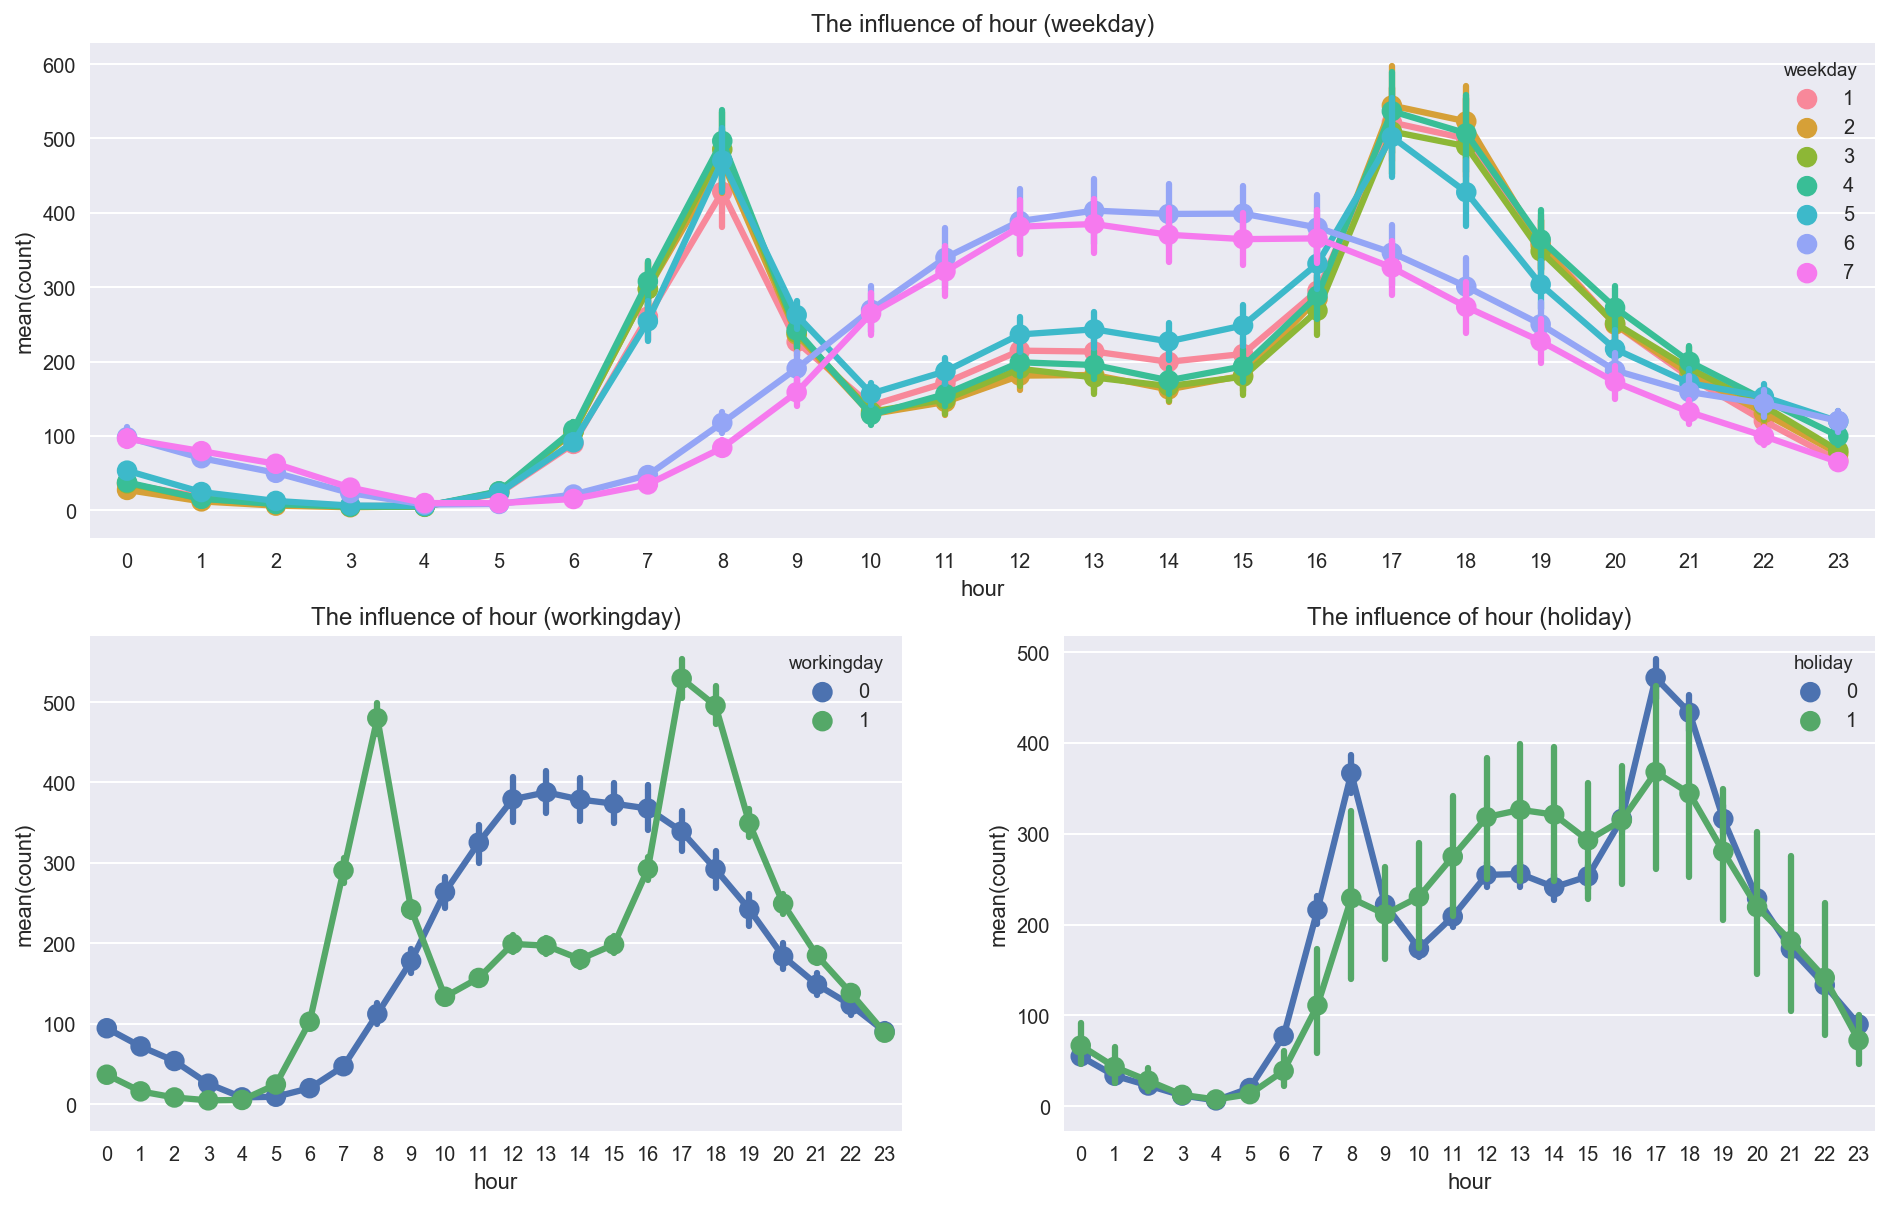

In [67]:
# fig,axes = plt.subplots(2,1,figsize=(16, 10))
plt.subplots(2, 1, figsize=(16, 10))
ax1 = plt.subplot(211)
sns.pointplot(train['hour'], train['count'], hue=train['weekday'], ax=ax1)
ax1.set_title("The influence of hour (weekday)")

ax2 = plt.subplot(223)
sns.pointplot(train['hour'], train['count'], hue=train['workingday'], ax=ax2)
ax2.set_title("The influence of hour (workingday)")

ax3 = plt.subplot(224)
sns.pointplot(train['hour'], train['count'], hue=train['holiday'], ax=ax3)
ax3.set_title("The influence of hour (holiday)")
plt.show()


/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


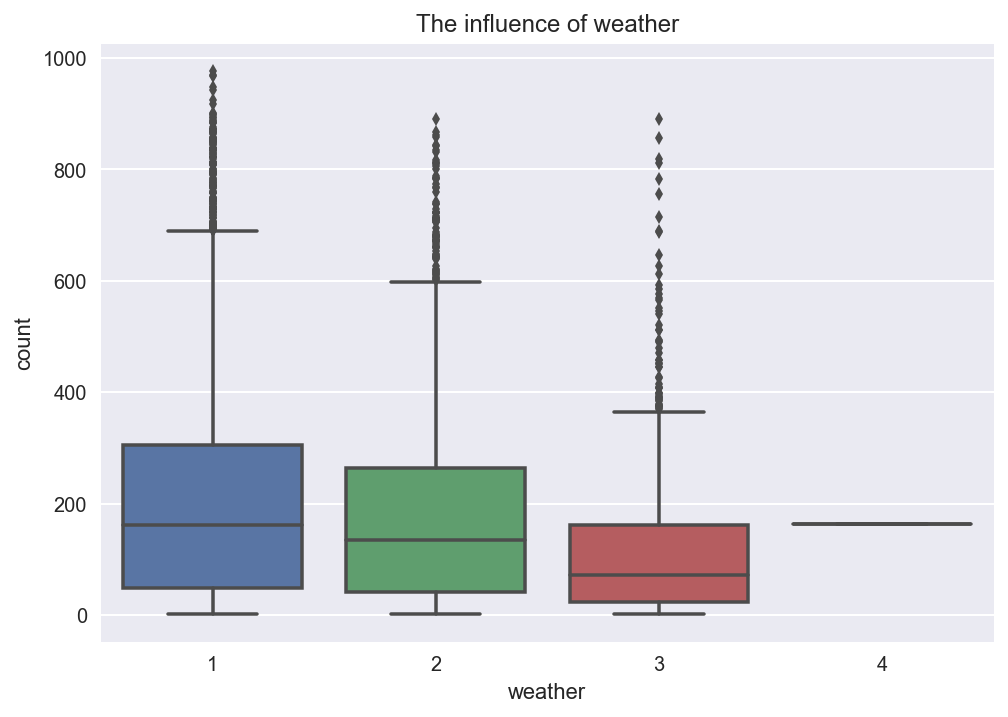

In [68]:
# 天气对租借数的影响

sns.boxplot(x='weather',y='count',data=train)
plt.title("The influence of weather")
plt.show()

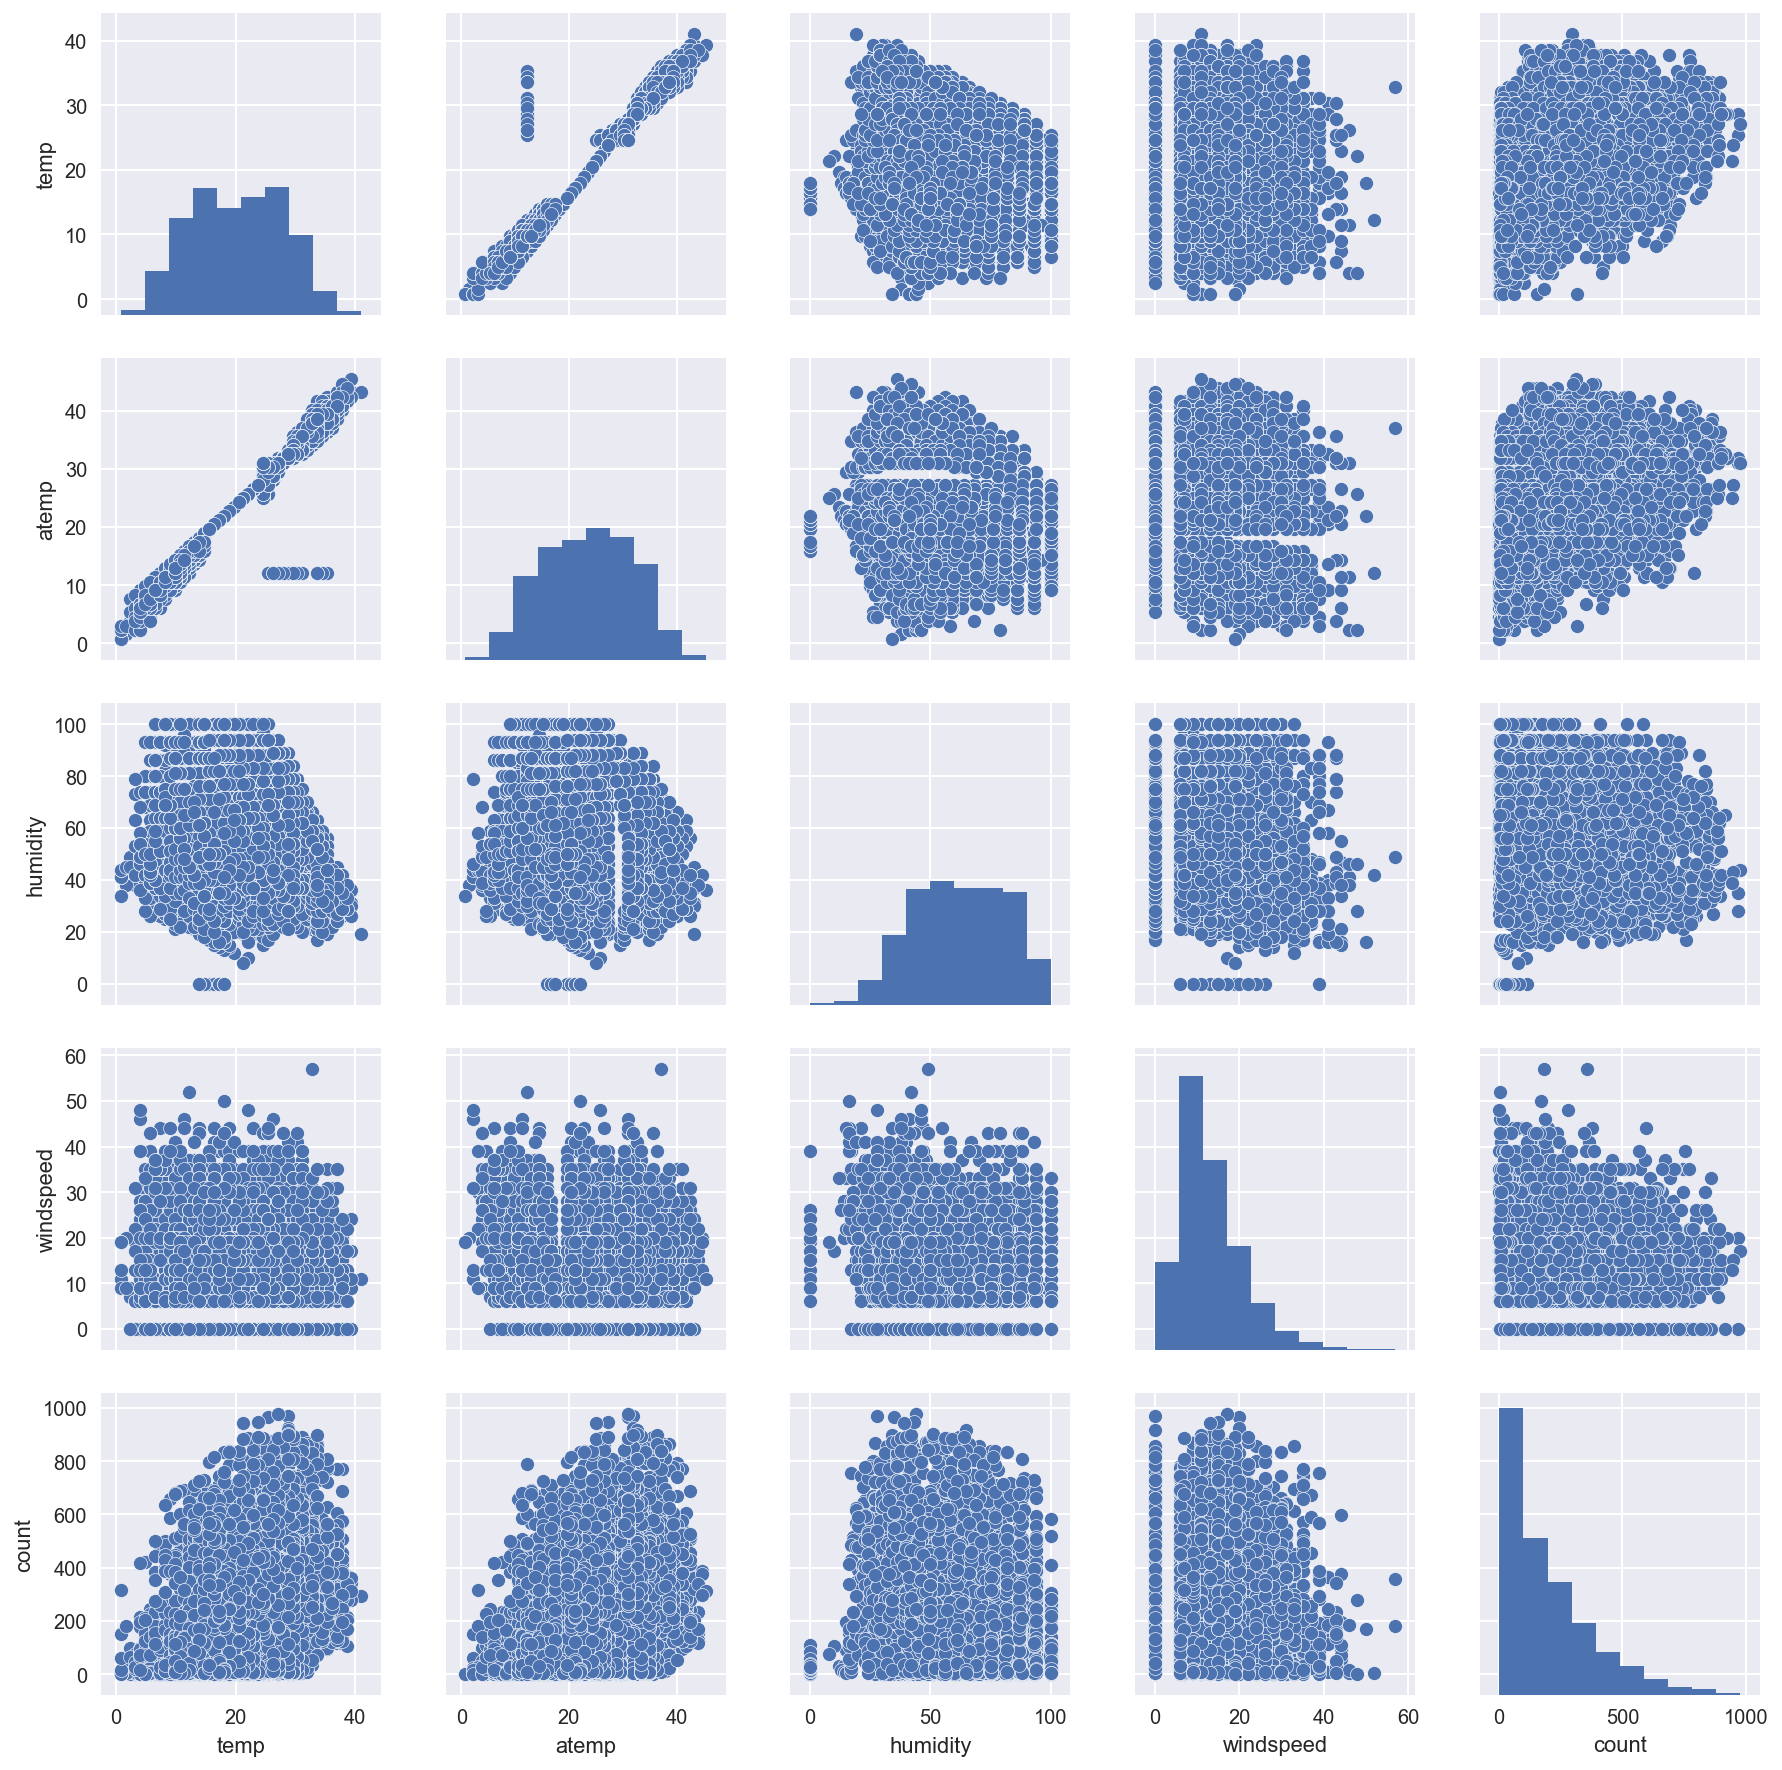

In [73]:
# 温度、湿度 humidity 、风速 windspeed 的影响
# train[['temp','atemp','humidity','windspeed','count']]
cols = ['temp','atemp','humidity','windspeed','count']
sns.pairplot(train[cols])
plt.show()

/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/scipy/stats/stats.py:1626: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


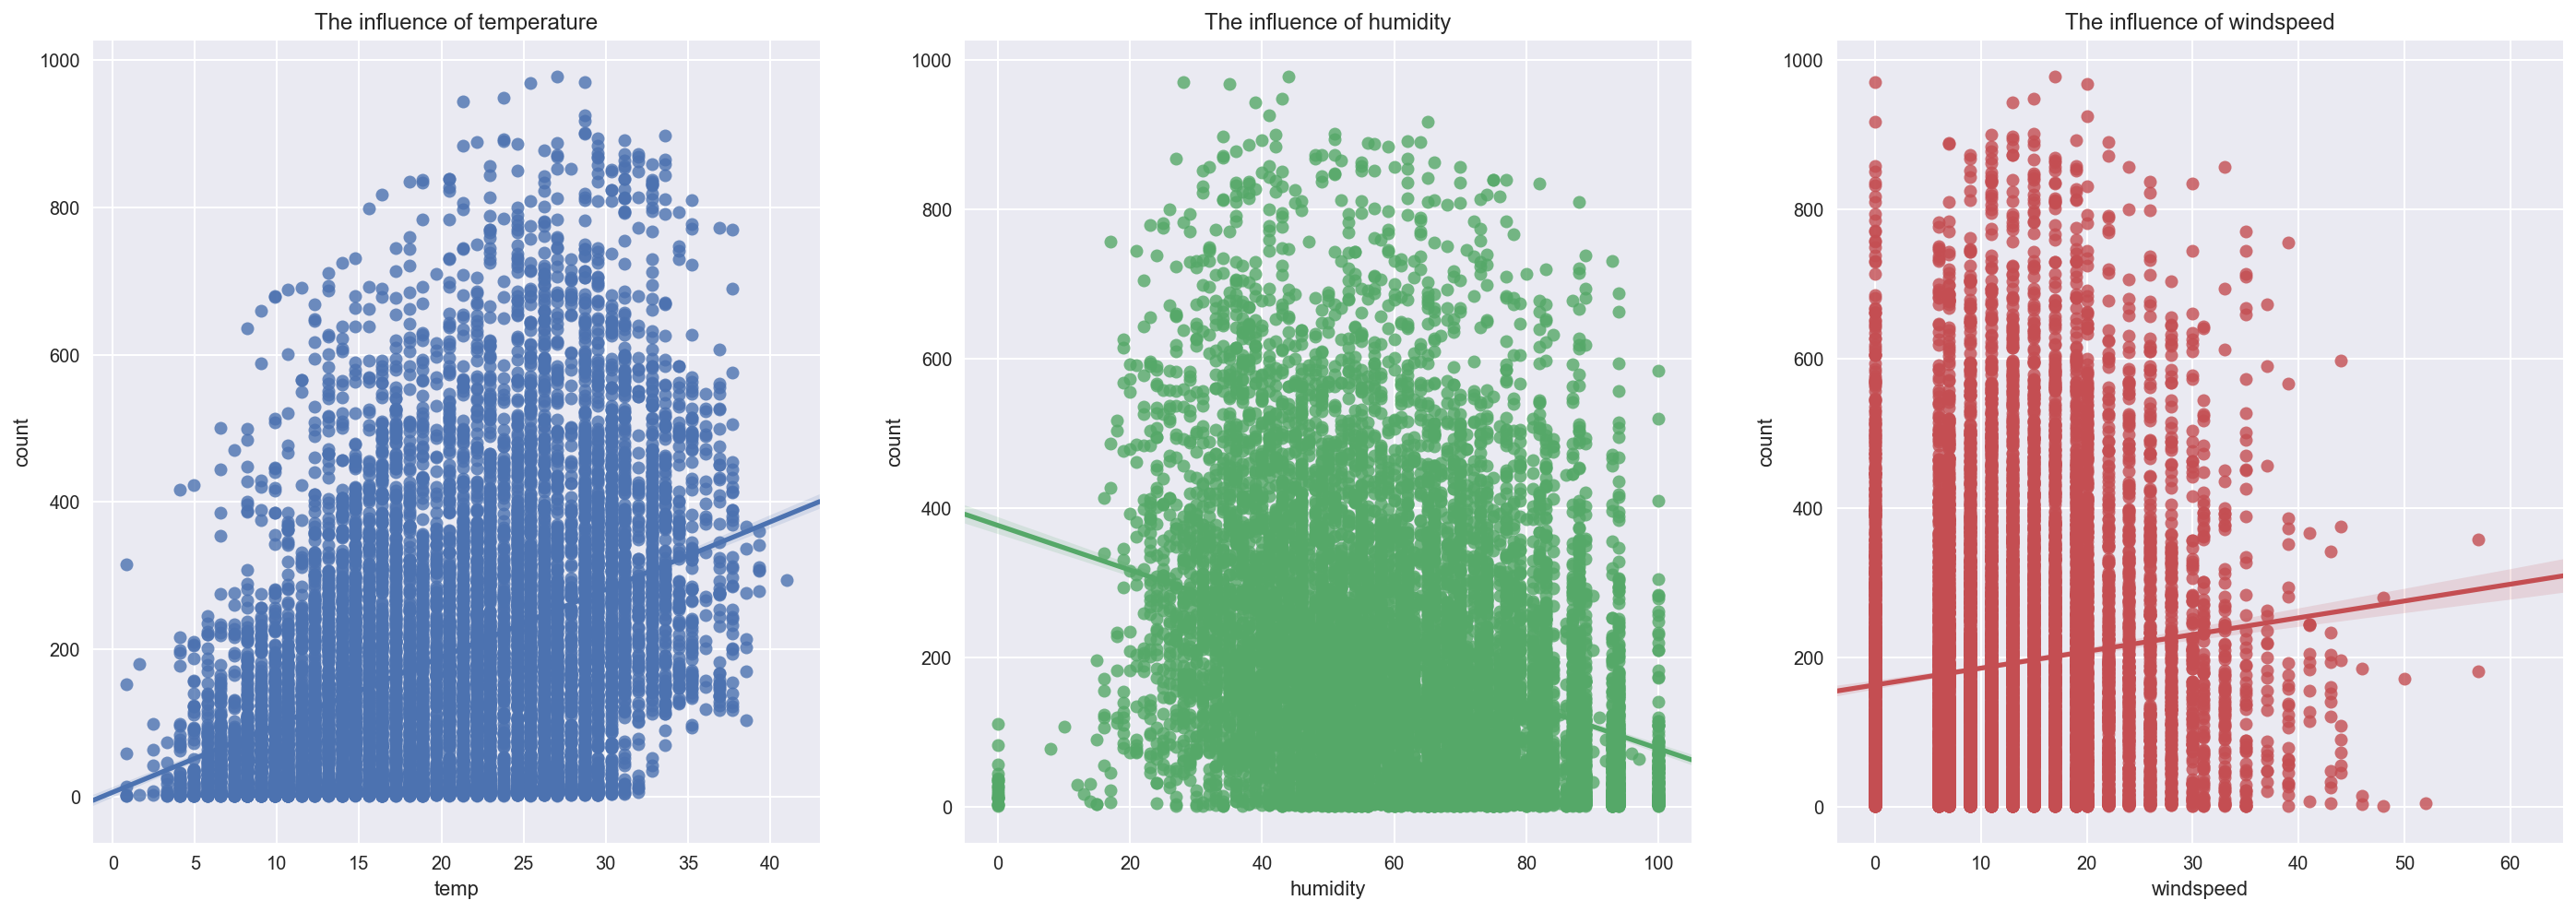

In [74]:
# fig, axes = plt.subplots(1,3,figsize=(24,8))
plt.subplots(1,3,figsize=(24,8))
ax1 = plt.subplot(1,3,1)
ax2 = plt.subplot(1,3,2)
ax3 = plt.subplot(1,3,3)
sn.regplot(train['temp'],train['count'],ax=ax1)
sn.regplot(train['humidity'],train['count'],ax=ax2)
sn.regplot(train['windspeed'],train['count'],ax=ax3)
ax1.set_title("The influence of temperature")
ax2.set_title("The influence of humidity")
ax3.set_title("The influence of windspeed")
plt.show()

## 特征工程

1. 删除不用的变量
2. 把离散型变量做独热编码



In [92]:
#特征工程
#所选取的特征：year、month、hour、workingday、holiday、weather、temp、humidity和windspeed
#(1) 删除不要的变量
data_train = train.drop(['day','weekday','season','atemp','casual','registered','count'],axis=1)
#(2) 离散型变量（year、month、hour、weather）转换
column_trans = ['year','month','hour','weather']
data_train = pd.get_dummies(data_train, columns=column_trans)

## 训练出一个基模型

In [94]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()
rfr.fit(data_train,train_data['count'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

## 对测试数据集使用同样的方式处理

In [95]:
#特征工程
#所选取的特征：year、month、hour、workingday、holiday、weather、temp、humidity和windspeed
#(1) 删除不要的变量
data_test = test.drop(['day','weekday','season','atemp','casual','registered','count'],axis=1)
#(2) 离散型变量（year、month、hour、weather）转换
column_trans = ['year','month','hour','weather']
data_test = pd.get_dummies(data_test, columns=column_trans)

In [97]:
y_pred = rfr.predict(data_test)

In [101]:
test

,year,month,day,weekday,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011,1,20,4,0,1,0,1,1,10.66,11.365,56,26.0027,NaN,NaN,NaN
1,2011,1,20,4,1,1,0,1,1,10.66,13.635,56,0.0000,NaN,NaN,NaN
2,2011,1,20,4,2,1,0,1,1,10.66,13.635,56,0.0000,NaN,NaN,NaN
3,2011,1,20,4,3,1,0,1,1,10.66,12.880,56,11.0014,NaN,NaN,NaN
4,2011,1,20,4,4,1,0,1,1,10.66,12.880,56,11.0014,NaN,NaN,NaN
5,2011,1,20,4,5,1,0,1,1,9.84,11.365,60,15.0013,NaN,NaN,NaN
6,2011,1,20,4,6,1,0,1,1,9.02,10.605,60,15.0013,NaN,NaN,NaN
7,2011,1,20,4,7,1,0,1,1,9.02,10.605,55,15.0013,NaN,NaN,NaN
8,2011,1,20,4,8,1,0,1,1,9.02,10.605,55,19.0012,NaN,NaN,NaN
9,2011,1,20,4,9,1,0,1,2,9.84,11.365,52,15.0013,NaN,NaN,NaN


In [104]:
result = pd.DataFrame({'datetime':test_data['datetime'],'count':y_pred})
result

,datetime,count
0,2011-01-20 00:00:00,8.7
1,2011-01-20 01:00:00,11.1
2,2011-01-20 02:00:00,3.7
3,2011-01-20 03:00:00,11.8
4,2011-01-20 04:00:00,10.5
5,2011-01-20 05:00:00,4.0
6,2011-01-20 06:00:00,38.0
7,2011-01-20 07:00:00,108.2
8,2011-01-20 08:00:00,252.9
9,2011-01-20 09:00:00,108.4


In [105]:


result.to_csv('./result.csv', index=None)